<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/Explore_TPU_MNIST_Tiny_SGD_run3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [4]:
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4139  100  4139    0     0  27593      0 --:--:-- --:--:-- --:--:-- 27593
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
     |████████████████████████████████| 61kB 2.7MB/s 
Uninstalling torch-1.5.1+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                             

In [5]:
!pip install fastai2 --upgrade > /dev/null

In [14]:
%cd /content/drive/My\ Drive/fastai_xla_extensions

/content/drive/My Drive/fastai_xla_extensions


In [15]:
!pip install -e ".[dev]"

Obtaining file:///content/drive/My%20Drive/fastai_xla_extensions
     |████████████████████████████████| 51kB 1.8MB/s 
  Running setup.py develop for fastai-xla-extensions


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
%cd /content

/content


### Import Libraries

In [18]:
from fastai2.vision.all import *

In [19]:
import torch_xla.core.xla_model as xm

In [20]:
%cd /content/drive/My\ Drive/fastai_xla_extensions

/content/drive/My Drive/fastai_xla_extensions


In [21]:
from fastai_xla_extensions.core import *

In [22]:
%cd /content

/content


### Setup data

In [23]:
path = untar_data(URLs.MNIST_TINY)

In [24]:
datablock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW),CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(),
    item_tfms=Resize(28),
    batch_tfms=[]
)

In [25]:
datablock.summary(path)

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_tiny/train/7/7331.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /root/.fastai/data/mnist_tiny/train/7/7331.png
    applying parent_label gives
      7
    applying Categorize gives
      TensorCategory(1)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(1))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImageBW mode=L size=28x28, TensorCategory(1))
    applying Resize gives
      (PILImageBW mode=L size=28x28, TensorCa

### Setup TPU

In [26]:
tpu = xm.xla_device()

### Setup DataLoaders

In [27]:
dls = datablock.dataloaders(path, device=tpu)

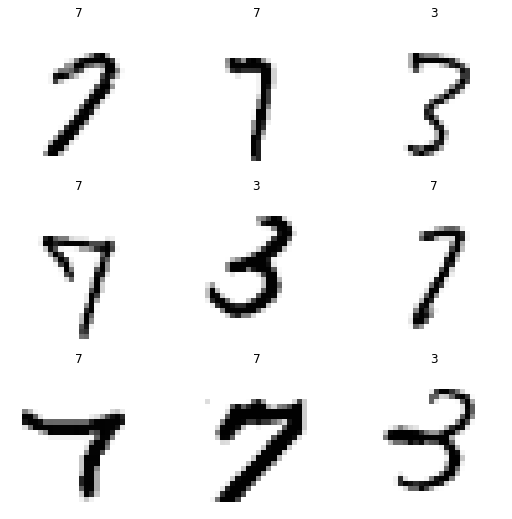

In [28]:
dls.show_batch()

### Create Learner

In [29]:
opt_func = XLAOptFuncWrapper(SGD)

In [30]:
learner = cnn_learner(dls,resnet18,metrics=accuracy,opt_func=opt_func)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [31]:
learner.summary()

Sequential (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 14 x 14    9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 14 x 14    128        True      
________________________________________________________________
ReLU                 64 x 64 x 14 x 14    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 64 x 7 x 7      36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 7 x 7      128        True      
________________________________________________________________
ReLU                 64 x 64 x 7 x 7      0          False     
___________________________________________________

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=0.0010000000474974513)

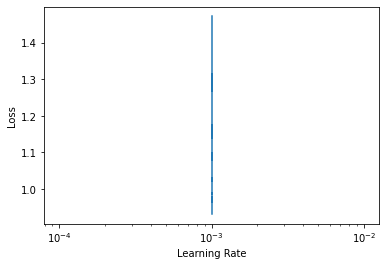

In [32]:
learner.lr_find()

In [33]:
learner.fit_one_cycle(1,lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.284616,0.589034,0.662375,00:07


In [34]:
learner.unfreeze()

In [35]:
learner.summary()

Sequential (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 14 x 14    9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 14 x 14    128        True      
________________________________________________________________
ReLU                 64 x 64 x 14 x 14    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 64 x 7 x 7      36,864     True      
________________________________________________________________
BatchNorm2d          64 x 64 x 7 x 7      128        True      
________________________________________________________________
ReLU                 64 x 64 x 7 x 7      0          False     
___________________________________________________

In [36]:
learner.fit_one_cycle(10,lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.856970,0.477797,0.736767,00:06
1,0.696570,0.318187,0.878398,00:02
2,0.575907,0.248524,0.905579,00:02
3,0.480952,0.211812,0.917024,00:02
4,0.416140,0.168745,0.947067,00:02
5,0.351597,0.148667,0.952790,00:02
6,0.310029,0.123891,0.954220,00:02
7,0.266777,0.130621,0.958512,00:02
8,0.233969,0.116354,0.964235,00:02
9,0.199138,0.116143,0.964235,00:02


In [38]:
learner.save('10epoch-one-cycle')

In [40]:
!cp /content/models/10epoch-one-cycle.pth  /content/drive/My\ Drive/fastai_v4/models/mnist_tiny_resnet18/.

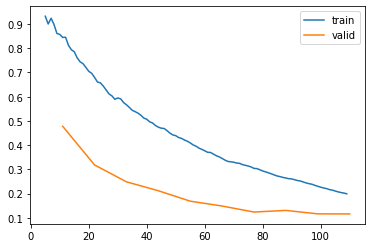

In [41]:
learner.recorder.plot_loss()

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=0.0010000000474974513)

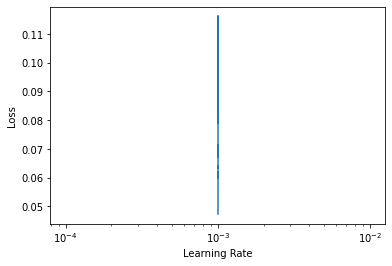

In [42]:
learner.lr_find()

In [43]:
learner.fit_one_cycle(10,lr_max=slice(1e-6,3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.083111,0.106771,0.955651,00:04
1,0.075497,0.100300,0.967096,00:02
2,0.075514,0.097819,0.959943,00:02
3,0.068384,0.091471,0.965665,00:02
4,0.064227,0.088386,0.962804,00:02
5,0.059240,0.083589,0.967096,00:02
6,0.055125,0.078009,0.971388,00:02
7,0.054131,0.079513,0.967096,00:02
8,0.051610,0.081785,0.969957,00:02
9,0.051097,0.080291,0.967096,00:02


In [44]:
learner.save('20epoch-one-cycle')

In [45]:
!cp /content/models/20epoch-one-cycle.pth  /content/drive/My\ Drive/fastai_v4/models/mnist_tiny_resnet18/.

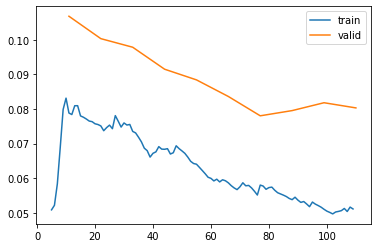

In [46]:
learner.recorder.plot_loss()